In [1]:
#SELECTION DEFINITION
THE_BIG_SELECTION_ORIGINAL = (
    "(D0_ENDVERTEX_CHI2 < 9) & "
    "((Dst_M - D0_M) > 139) & ((Dst_M - D0_M) < 151) & "
    "(D0_M > 1830) & (D0_M < 1890) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 1.7) & (pi_TRACK_CHI2NDOF < 1.7) & "
    "(K_PT > 250) & (pi_PT > 250) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(K_ProbNNghost < 0.3) & (pi_ProbNNghost < 0.3) & "
    "(K_ProbNNk > 0.1) & (pi_ProbNNpi > 0.1) & "
    "(mp_TRACK_CHI2NDOF < 2) & "
    "(mm_TRACK_CHI2NDOF < 2) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 700) & (mm_PT > 700) & "
    "(mp_IPCHI2_OWNPV > 2) & (mm_IPCHI2_OWNPV > 2) & "
    "(Jpsi_M < 3140) & (Jpsi_M > 3040) & "
    "(Jpsi_ENDVERTEX_CHI2 < 5) & "
    "(Dst_ENDVERTEX_CHI2 < 9) & "
    "(abs(Dst_M - 2010) < 40) & "
    "(Dst_PT > 2700) & "
    "(pi_soft_PT > 250) & "
    "(pi_soft_TRACK_CHI2NDOF < 2) & "
    "(pi_soft_TRACK_GhostProb < 0.4) & "
    "(Bc_ENDVERTEX_CHI2 < 4.2) & "
    "(Bc_IPCHI2_OWNPV < 10) & "
    "(Bc_DIRA_OWNPV > 0.99)"
)
THE_BIG_SELECTION = (
    "((Dst_M - D0_M) > 139) & ((Dst_M - D0_M) < 151) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 1.7) & (pi_TRACK_CHI2NDOF < 1.7) & "
    "(K_PT > 250) & (pi_PT > 250) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 2) & "
    "(mm_TRACK_CHI2NDOF < 2) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 700) & (mm_PT > 700) & "
    "(mp_IPCHI2_OWNPV > 2) & (mm_IPCHI2_OWNPV > 2) & "
    "(Jpsi_M < 3140) & (Jpsi_M > 3040) & "
    "(pi_soft_PT > 250) & "
    "(Bc_ENDVERTEX_CHI2 < 4.2) & "
    "(Bc_IPCHI2_OWNPV < 10) & "
    "(Bc_DIRA_OWNPV > 0.99)"
)


In [2]:
#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
from datetime import datetime
import optuna
import joblib

/Users/khrystina/virtenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#DATA DOWNLOADING
files_simu = [
    './simulation/2011_MagDown.root', 
    './simulation/2015_MagDown.root',
    './simulation/2015_MagUp.root',
    './simulation/2016_MagDown.root',
    './simulation/2016_MagUp.root',
    './simulation/2017_MagDown.root',
    './simulation/2017_MagUp.root',
    './simulation/2018_MagDown.root',
    './simulation/2018_MagUp.root'
]

files_real_data = [
    './real_data/2011_MagDown.root', 
    './real_data/2011_MagUp.root',
    './real_data/2012_MagDown.root', 
    './real_data/2012_MagUp.root',
    './real_data/2015_MagDown.root', 
    './real_data/2015_MagUp.root',
    './real_data/2016_MagDown.root', 
    './real_data/2016_MagUp.root',
    './real_data/2017_MagDown.root', 
    './real_data/2017_MagUp.root',
    './real_data/2018_MagDown.root', 
    './real_data/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = f"{THE_BIG_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{THE_BIG_SELECTION} & (Bc_M > 6600.)", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_4291/2730945960.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_4291/2730945960.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


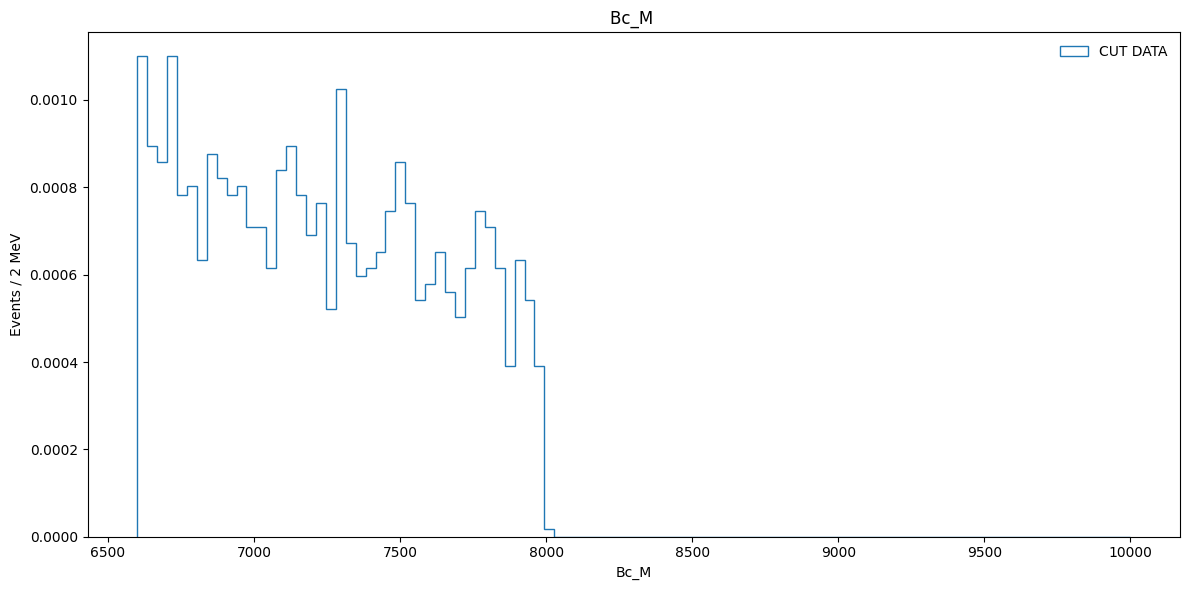

In [4]:
#CHECKING BACKGROUND
fig, axes = plt.subplots(figsize=(12, 6))
axes.hist(real_data['Bc_M'],density = True, bins=100, range =(6600,10000), histtype='step', label='CUT DATA')
axes.set_xlabel('Bc_M')
axes.set_ylabel('Events / 2 MeV')
axes.set_title('Bc_M ')
axes.legend(frameon=False)


plt.tight_layout()
plt.show()

In [5]:
#DEFINING TRAINING FEATURES
feature_columns_original = [
    'delta_mass', 
    'D0_ENDVERTEX_CHI2', 
    'D0_M', 
    'K_IPCHI2_OWNPV',
    'pi_IPCHI2_OWNPV',
    'K_TRACK_CHI2NDOF',
    'pi_TRACK_CHI2NDOF',
    'K_PT',
    'pi_PT',
    'K_hasRich',
    'pi_hasRich',
    'K_ProbNNghost',
    'pi_ProbNNghost',
    'K_ProbNNk',
    'pi_ProbNNpi',
    'mp_TRACK_CHI2NDOF',
    'mm_TRACK_CHI2NDOF',
    'mp_PT',
    'mm_PT',
    'mp_IPCHI2_OWNPV',
    'mm_IPCHI2_OWNPV',
    'Jpsi_M',
    'Jpsi_ENDVERTEX_CHI2',
    'Dst_ENDVERTEX_CHI2',
    'Dst_PT',
    'pi_soft_PT',
    'pi_soft_TRACK_CHI2NDOF',
    'pi_soft_TRACK_GhostProb',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',
    'Bc_DIRA_OWNPV'
    ]

feature_columns_nice = [

    'K_TRACK_CHI2NDOF',
    'pi_TRACK_CHI2NDOF',
    'mp_TRACK_CHI2NDOF',
    'mm_TRACK_CHI2NDOF',
    'mp_PT',
    'mm_PT',
    'mp_IPCHI2_OWNPV',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',
    'D0_ENDVERTEX_CHI2',
    'Dst_ENDVERTEX_CHI2',
    'pi_soft_TRACK_CHI2NDOF',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX'
    ]

feature_columns = [

    'mp_PT',
    'mm_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX'
    ]

In [6]:

# Separate features and labels
X_simu = simu_data[feature_columns]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)
y_all = np.concatenate([y_simu, y_real])

print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")


SIMULATION set size: (28662, 7)
REAL DATA set size: (1577, 7)


In [7]:
#TIME FUNCTION


def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    else:
        elapsed_time = datetime.now() - start_time
        thour, temp_sec = divmod(elapsed_time.total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %d hours, %d minutes, and %.2f seconds.' % (int(thour), int(tmin), tsec))


In [8]:
#IMPLEMENTING OPTUNA TO FIND THE BEST MODEL


X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=76)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 20)
    }
    model_optuna = XGBClassifier(**params, random_state=52, eval_metric="logloss")
    model_optuna.fit(X_train, y_train)
    preds = model_optuna.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, preds)
    if not hasattr(objective, 'best_score') or score > objective.best_score:
        objective.best_score = score
        objective.best_model = model_optuna 
    return score

# Optimize
study = optuna.create_study(direction="maximize")
start_time = timer(None)
study.optimize(objective, n_trials=400)
best_model = objective.best_model
joblib.dump(best_model, "best_optuna_model.pkl")
timer(start_time)

print("Best parameters:", study.best_params)
print("Best ROC-AUC Score:", study.best_value)
print("Best model saved as 'best_optuna_model.pkl'")


[I 2025-01-23 16:10:08,991] A new study created in memory with name: no-name-047982b6-fda0-4a7b-957e-353bd5c329ff


Training set size: (24191, 7)
Test set size: (6048, 7)


[I 2025-01-23 16:10:10,784] Trial 0 finished with value: 0.9593249417396398 and parameters: {'n_estimators': 451, 'learning_rate': 0.11636670150237255, 'max_depth': 13}. Best is trial 0 with value: 0.9593249417396398.
[I 2025-01-23 16:10:12,575] Trial 1 finished with value: 0.9595700687564206 and parameters: {'n_estimators': 365, 'learning_rate': 0.13425047150291472, 'max_depth': 19}. Best is trial 1 with value: 0.9595700687564206.
[I 2025-01-23 16:10:13,898] Trial 2 finished with value: 0.9570100284011045 and parameters: {'n_estimators': 424, 'learning_rate': 0.27693133966605005, 'max_depth': 10}. Best is trial 1 with value: 0.9595700687564206.
[I 2025-01-23 16:10:15,213] Trial 3 finished with value: 0.959565865077676 and parameters: {'n_estimators': 261, 'learning_rate': 0.1573111889399205, 'max_depth': 20}. Best is trial 1 with value: 0.9595700687564206.
[I 2025-01-23 16:10:16,699] Trial 4 finished with value: 0.9613765996968097 and parameters: {'n_estimators': 326, 'learning_rate':


 Time taken: 0 hours, 2 minutes, and 45.09 seconds.
Best parameters: {'n_estimators': 272, 'learning_rate': 0.12471515852799854, 'max_depth': 2}
Best ROC-AUC Score: 0.9705253810240687
Best model saved as 'best_optuna_model.pkl'


In [9]:
# #CORRELATING MAP
# import seaborn as sns

# # Compute the correlation matrix
# correlation_matrix_simu = X_simu.corr()

# # Plot the heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix_simu, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
# plt.title("Correlation Matrix of Features for simulation:")
# plt.show()

# # Identify highly correlated pairs
# threshold = 0.6  # Define a correlation threshold
# high_corr_pairs = correlation_matrix_simu.unstack().sort_values(ascending=False)
# high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]  # Remove self-correlations
# high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]  # Filter by threshold

# print("Highly correlated feature pairs for simulation:\n", high_corr_pairs)

# # Compute the correlation matrix
# correlation_matrix_real = X_real.corr()

# # Plot the heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(correlation_matrix_real, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
# plt.title("Correlation Matrix of Features for real data:")
# plt.show()

# # Identify highly correlated pairs
# threshold = 0.6  # Define a correlation threshold
# high_corr_pairs = correlation_matrix_real.unstack().sort_values(ascending=False)
# high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]  # Remove self-correlations
# high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]  # Filter by threshold

# print("Highly correlated feature pairs for real data:\n", high_corr_pairs)


In [10]:
#MODEL WITH EARLY STOPPING

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pickle

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=8)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Load Optuna-saved model parameters
with open("best_optuna_model.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(best_model_params)  # Inspect its contents
except ImportError as e:
    print("ImportError occurred:", e)


# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()

# Add necessary static parameters to avoid conflicts
best_model_params.update({
    'random_state': 31,   # Ensure reproducibility
    'use_label_encoder': False,  # Required for compatibility
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20   # Required for binary classification
})

# Initialize the XGBClassifier with the parameters
model_es = XGBClassifier(**best_model_params)

# Fit the model with early stopping
model_es.fit(
    X_train, 
    y_train,  
    eval_set=[(X_test, y_test)], 
    verbose=True
    )


# Save the trained model
model_es.save_model("best_early_stopping_model.json")

# Predict on the test set
y_pred = model_es.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Training set size: (24191, 7)
Test set size: (6048, 7)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12471515852799854, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=272, n_jobs=None,
              num_parallel_tree=None, random_state=52, ...)
[0]	validation_0-logloss:0.22681
[1]	validation_0-logloss:0.21095
[2]	validation_0-logloss:0.19846
[3]	validation_0-logloss:0.18754
[4]	validation_0-logloss:0.

[14]	validation_0-logloss:0.13095
[15]	validation_0-logloss:0.12811
[16]	validation_0-logloss:0.12599
[17]	validation_0-logloss:0.12394
[18]	validation_0-logloss:0.12225
[19]	validation_0-logloss:0.12035
[20]	validation_0-logloss:0.11861
[21]	validation_0-logloss:0.11739
[22]	validation_0-logloss:0.11603
[23]	validation_0-logloss:0.11486
[24]	validation_0-logloss:0.11359
[25]	validation_0-logloss:0.11238
[26]	validation_0-logloss:0.11115
[27]	validation_0-logloss:0.11029
[28]	validation_0-logloss:0.10940
[29]	validation_0-logloss:0.10840
[30]	validation_0-logloss:0.10750
[31]	validation_0-logloss:0.10685
[32]	validation_0-logloss:0.10622
[33]	validation_0-logloss:0.10552
[34]	validation_0-logloss:0.10496
[35]	validation_0-logloss:0.10434
[36]	validation_0-logloss:0.10361
[37]	validation_0-logloss:0.10306
[38]	validation_0-logloss:0.10243
[39]	validation_0-logloss:0.10192
[40]	validation_0-logloss:0.10137
[41]	validation_0-logloss:0.10094
[42]	validation_0-logloss:0.10064
[43]	validatio

/Users/khrystina/virtenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:12:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-logloss:0.09000
[101]	validation_0-logloss:0.09003
[102]	validation_0-logloss:0.09001
[103]	validation_0-logloss:0.08995
[104]	validation_0-logloss:0.08992
[105]	validation_0-logloss:0.08992
[106]	validation_0-logloss:0.08987
[107]	validation_0-logloss:0.08976
[108]	validation_0-logloss:0.08971
[109]	validation_0-logloss:0.08970
[110]	validation_0-logloss:0.08966
[111]	validation_0-logloss:0.08960
[112]	validation_0-logloss:0.08963
[113]	validation_0-logloss:0.08957
[114]	validation_0-logloss:0.08951
[115]	validation_0-logloss:0.08940
[116]	validation_0-logloss:0.08939
[117]	validation_0-logloss:0.08937
[118]	validation_0-logloss:0.08935
[119]	validation_0-logloss:0.08940
[120]	validation_0-logloss:0.08935
[121]	validation_0-logloss:0.08937
[122]	validation_0-logloss:0.08929
[123]	validation_0-logloss:0.08925
[124]	validation_0-logloss:0.08915
[125]	validation_0-logloss:0.08915
[126]	validation_0-logloss:0.08915
[127]	validation_0-logloss:0.08917
[128]	validation_0-l

In [11]:

# Predict on the test set
y_pred = model_es.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.51      0.62       313
         1.0       0.97      0.99      0.98      5735

    accuracy                           0.97      6048
   macro avg       0.88      0.75      0.80      6048
weighted avg       0.96      0.97      0.96      6048



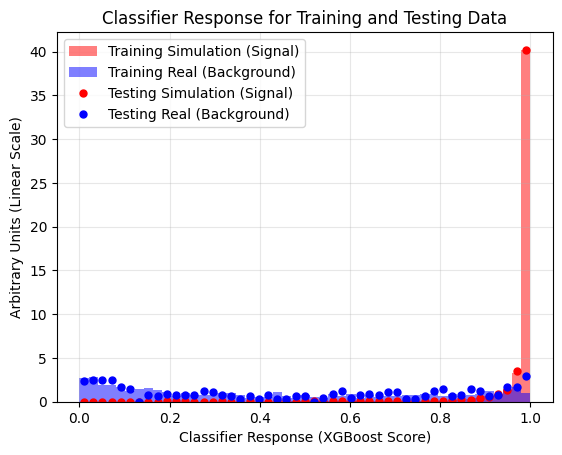

In [16]:

# Combine signal and background predictions for each set
train_sim_signal = model_es.predict_proba(X_train[y_train == 1])[:, 1]
train_real_background = model_es.predict_proba(X_train[y_train == 0])[:, 1]
test_sim_signal = model_es.predict_proba(X_test[y_test == 1])[:, 1]
test_real_background = model_es.predict_proba(X_test[y_test == 0])[:, 1]

# Define bins for histograms
bins = np.linspace(0, 1, 50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Histograms for training data
train_sim_hist, _ = np.histogram(train_sim_signal, bins=bins, density=True)
train_real_hist, _ = np.histogram(train_real_background, bins=bins, density=True)

# Histograms for test data (used for alignment)
test_sim_hist, _ = np.histogram(test_sim_signal, bins=bins, density=True)
test_real_hist, _ = np.histogram(test_real_background, bins=bins, density=True)

# Plot histograms for training data
plt.hist(train_sim_signal, bins=bins, alpha=0.5, label="Training Simulation (Signal)", color="red", density=True, histtype="stepfilled")
plt.hist(train_real_background, bins=bins, alpha=0.5, label="Training Real (Background)", color="blue", density=True, histtype="stepfilled")

# Plot test data as dots
plt.plot(bin_centers, test_sim_hist, 'o', label="Testing Simulation (Signal)", color="red", markersize=5)
plt.plot(bin_centers, test_real_hist, 'o', label="Testing Real (Background)", color="blue", markersize=5)

# Labels, legend, and title
plt.xlabel("Classifier Response (XGBoost Score)")
plt.ylabel("Arbitrary Units (Linear Scale)")
plt.title("Classifier Response for Training and Testing Data")
plt.legend()
#plt.yscale("log")  # Logarithmic scale for better visualization
plt.grid(alpha=0.3)

plt.show()


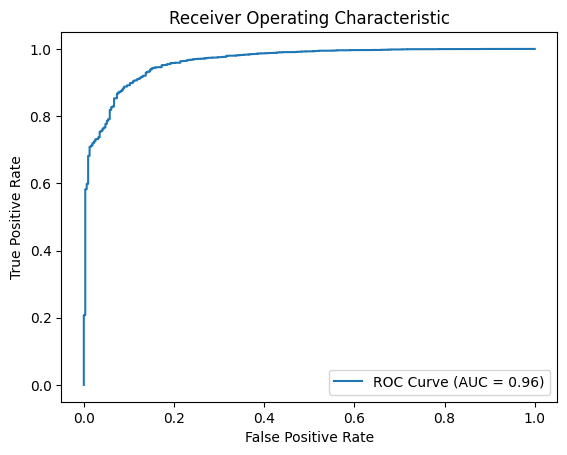

In [13]:

y_prob = model_es.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


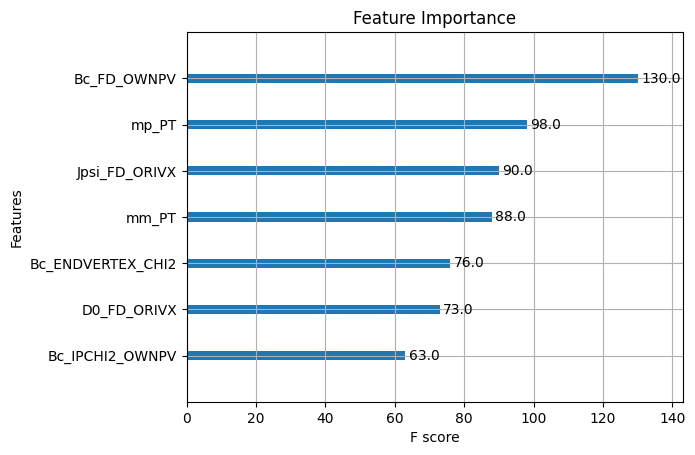

In [14]:

# Plot feature importance
plot_importance(model_es, importance_type='weight')
plt.title("Feature Importance")
plt.show()
